In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import seaborn as sns

sns.set_style('whitegrid')

/kaggle/input/mock-data/MOCK_DATA.csv


Implementation is adapted from: https://pbpython.com/monte-carlo.html

# Objective: 

Supply/shopper allocation is an importat business problem because if we have too few, we lose out on potential revenue. And if we have too many, we have idle shoppers and risk churn to other on-demand platforms.

Inferring supply in grocery tech is a complex problem due to the high amount of variance that happens in attempting to deliver groceries from store to customer. Some examples include store hours, shopper availability, traffic conditions, holidays, shopper skill level, etc. In order to simulate this in real life, a promising solution is to use Monte Carlo simulations. What this does is give all possible scenarios and probabilities associated with each probable outcome. Then we can make an informed decision on how a certain future event will play out. And in our case, it would be for a given time window, how many shoppers will be needed in order to help get groceries from point A to point B. So let's get started!

# Data
We have some historical data that was used in hts forecasting. Let's import that in again. 

In [2]:
df = pd.read_csv('../input/mock-data/MOCK_DATA.csv')
df

,start_at,market_name,neighborhood_name,orders_count,distinct_count_fulfilled_shoppers
0,2017-03-08T18:53:58Z,California,Inglewood,1,6
1,2017-03-27T23:20:20Z,California,Los Angeles,2,6
2,2017-03-22T21:35:16Z,California,Stockton,3,1
3,2017-03-23T06:13:34Z,Pennsylvania,Bethlehem,3,6
4,2017-03-30T09:23:39Z,California,Sacramento,4,3
...,...,...,...,...,...
995,2017-03-29T18:00:03Z,Pennsylvania,Lancaster,3,3
996,2017-03-16T20:34:06Z,Pennsylvania,Philadelphia,3,5
997,2017-03-01T06:56:06Z,California,Sacramento,2,1
998,2017-03-31T17:22:40Z,California,Santa Barbara,2,1


# Monte Carlo
At its basic level, Monte Carlo simulation involves running many scenarios with different random inputs and summarizing the distribution of results.

Distribution can inform likelihood that supply will be within a certain window of values. Caveat: this is a prediction so we will likely never predict exactly. Though with this simulation we can develop a more informed idea about the potential risk of under or over supplying.

## Two components to running a Monte Carlo simulation
    1. equation to evaluate
    2. the random variables for the input

In our situation, the equation would involve minimizing shopper ideleness (idlenesss cost) and maximizing shopper availability (lost deliveries cost).

Red line is predicted supply at certain hour of time. And gray line is the actual value. Wherever there is a gap- described as idleness cost/lost deliveries cost. This is what we want to minimize so that predicted line converges on actual line. This can be achieved through reoccuring simulations/keep sampling from all possible set of values to get most likely (mean) value at specific hour of time.

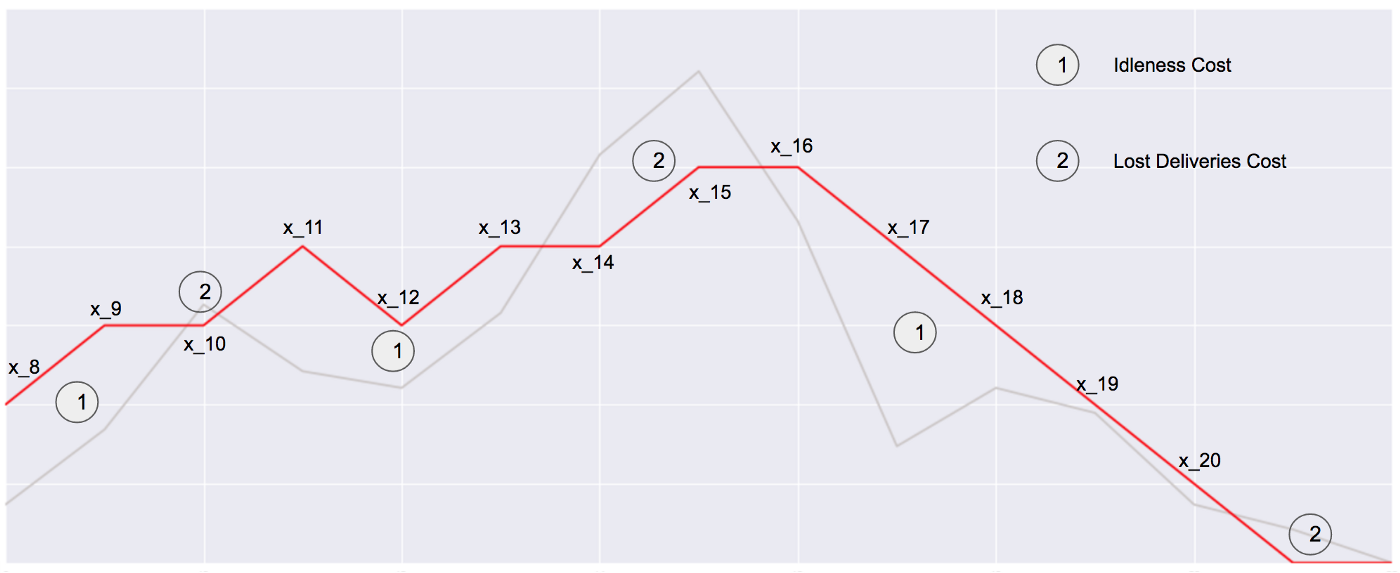

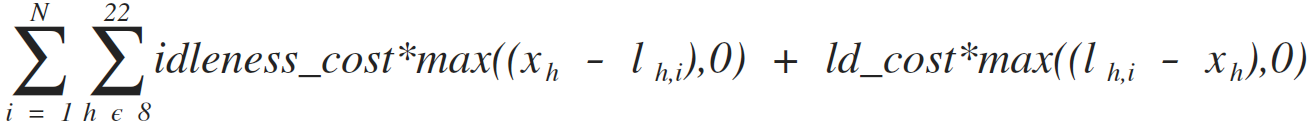

These would be the random variables for the input:

* N: number of simulation runs
* h: hour of day
* ld_cost: lost deliveries cost
* x_h: non-negative integer variables
* l_h,i: shoppers required at hour h in simulation i

By running a simulation 100's or even 1000's of times, will get a distribution of potential shoppers at a given delivery time window.

**Simplified equation** to get distribution of shoppers per given delivery window time:

Per simulation iteration, per hour in delivery time range, 
prev shopper # x % off from target = # shoppers (updated)

At the end, want a distribution of shoppers for each delivery time window.

# Building the Model

Without historical percent target off data, will assume it takes normal distribution  with below average and std dev to proceed with simulation. 

Below, we define distribution variables and # simulations.

In [3]:
avg = 1
std_dev = .5
num_delivery_windows = 1000
num_simulations = 2000

Generate list of target off percentages that will replicate historical normal distribution.

In [4]:
pct_to_target = np.random.normal(avg, std_dev, num_delivery_windows)
pct_to_target

array([ 1.63524991e+00,  1.75396296e+00,  1.23607553e+00,  1.02046741e+00,
        1.70920449e+00,  8.01402921e-01,  3.21292809e-01,  5.76390555e-01,
        1.21285384e+00,  1.31000033e+00, -1.35410446e-01,  8.45149010e-01,
        1.31545776e+00,  1.37160606e+00,  8.28841820e-01,  1.54058389e+00,
        9.64536995e-01,  1.36388606e+00,  1.01264173e+00,  1.41047475e+00,
        7.90944756e-01,  1.09437330e+00,  5.89446698e-01,  1.41634224e+00,
        4.50595004e-01,  1.33758953e+00,  2.57355365e-01,  1.30444018e+00,
        3.69262898e-01,  7.85171792e-01,  3.86779159e-01,  8.89586287e-01,
        1.47413272e+00,  1.05586520e+00,  7.42351328e-01,  7.33119831e-01,
        1.43762694e+00,  1.62863727e+00,  1.01018532e+00,  8.42168474e-01,
        9.70868162e-01,  9.14650240e-01,  1.23738656e+00,  1.35296435e+00,
        1.59648356e+00,  9.31789310e-01,  5.73731031e-01,  1.77049480e+00,
        4.76624960e-01,  1.14405139e+00,  1.31480151e+00,  1.46026110e+00,
        5.62296046e-01,  

Above numbers are showing that there will be under and overshot shopper number predictions.

In order to calculate an updated amount of shoppers, we will pull in historical data of shoppers assigned at specific delivery windows. Let's first take a look at its distibution and have it as a baseline in order to simulate the same distribution for our updated predictions.

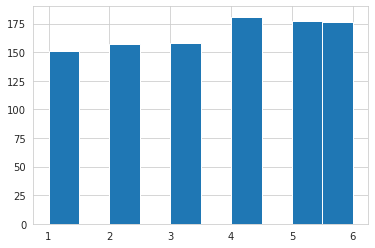

In [5]:
df.distinct_count_fulfilled_shoppers.hist()

This is a uniform distribution. Shoppers take on 1 of 6 buckets and 4-6 shoppers per delivery window have the highest frequency. Having low number of shoppers available per delivery window would be a bad sign. In order to simulate this as well will use uniform distribution but assign lower probability weights for some of the lower values.

In [6]:
prev_shopper_values = [1,2,3,4,5,6]
shopper_values_prob = [.12,.14,.11,.21,.21,.21]
prev_no_shoppers = np.random.choice(prev_shopper_values, num_delivery_windows, p=shopper_values_prob)

Now that we have our two input distributions , let's build up our Pandas df. 

In [7]:
df2 = pd.DataFrame(index=range(num_delivery_windows), data={'Pct_To_Target': pct_to_target,
                                               'Prev_No_Shoppers_Assigned': prev_no_shoppers})

df2['Update_No_Shoppers'] = df2['Pct_To_Target'] * df2['Prev_No_Shoppers_Assigned']
df2['Update_No_Shoppers'] = df2['Update_No_Shoppers'].round()
df2['Update_No_Shoppers'] = df2['Update_No_Shoppers'].astype(int)
df2

,Pct_To_Target,Prev_No_Shoppers_Assigned,Update_No_Shoppers
0,1.635250,4,7
1,1.753963,3,5
2,1.236076,6,7
3,1.020467,4,4
4,1.709204,4,7
...,...,...,...
995,1.554055,1,2
996,1.671907,3,5
997,0.769309,6,5
998,1.614243,6,10


Let's see for this sample size of 1000, what is the Update_No_Shoppers distribution.

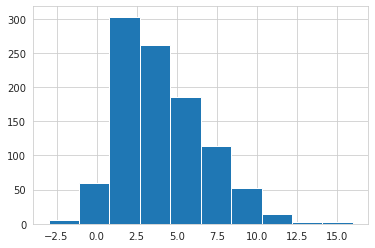

In [8]:
df2['Update_No_Shoppers'].hist()

We can see here that there may be some days in which an undersupply is good and that there may be as many as 12 shoppers needed to meet demand at times. The most popular amounts are about 2-7 shoppers for a given delivery window.

# Simulating Grocery-Tech Universe

The real "magic" of the Monte Carlo simulation is that if we run a simulation many times, we start to develop a picture of the likely distribution of results. We can use a for loop to run as many simululations as we'd like.

We'll save results we care about in a list that we will turn into a df for further analysis of distribution results.

In [18]:
# Define a list to keep all the results from each simulation that we want to analyze
all_stats = []

# Loop through many simulations
for i in range(num_simulations):

    # Choose random inputs for prev_no_shoppers and percent to target
    prev_no_shoppers = np.random.choice(prev_shopper_values, num_delivery_windows, p=shopper_values_prob)
    pct_to_target = np.random.normal(avg, std_dev, num_delivery_windows)

    # Build the dataframe based on the inputs and number of delivery windows
    df3 = pd.DataFrame(index=range(num_delivery_windows), data={'Pct_To_Target': pct_to_target,
                                               'Prev_No_Shoppers_Assigned': prev_no_shoppers})
    
    #Update number of shopper based on prev no.shoppers and percent to target
    df3['Update_No_Shoppers'] = df3['Pct_To_Target'] * df3['Prev_No_Shoppers_Assigned']
    df3['Update_No_Shoppers'] = df3['Update_No_Shoppers'].round()
    df3['Update_No_Shoppers'] = df3['Update_No_Shoppers'].astype(int)

    # We want to track prev no. of shoppers,target value percent and updated shopper no. over all the simulations
    all_stats.append([df3['Prev_No_Shoppers_Assigned'],
                      df3['Pct_To_Target'],
                      df3['Update_No_Shoppers']])

In [19]:
#All possible values at a given delivery window time frame
results_df = pd.DataFrame.from_records(all_stats, columns=['Prev_No_Shoppers_Assigned',
                                                           'Pct_To_Target',
                                                           'Update_No_Shoppers'])
results_df

,Prev_No_Shoppers_Assigned,Pct_To_Target,Update_No_Shoppers
0,0 4 1 6 2 1 3 1 4 4 ...,0 1.089262 1 1.549243 2 2.17279...,0 4 1 9 2 2 3 1 4 6 ...
1,0 1 1 2 2 2 3 1 4 5 ...,0 1.216887 1 1.460352 2 0.23668...,0 1 1 3 2 0 3 1 4 7 ...
2,0 3 1 6 2 4 3 4 4 6 ...,0 2.004602 1 1.140969 2 1.80370...,0 6 1 7 2 7 3 3 4 ...
3,0 3 1 5 2 6 3 1 4 1 ...,0 0.882534 1 1.003043 2 1.07956...,0 3 1 5 2 6 3 1 4 2 ...
4,0 6 1 6 2 4 3 4 4 5 ...,0 0.398386 1 1.137238 2 0.23685...,0 2 1 7 2 1 3 1 4 3 ...
...,...,...,...
1995,0 2 1 4 2 1 3 5 4 6 ...,0 1.281857 1 1.620384 2 1.20691...,0 3 1 6 2 1 3 3 4 ...
1996,0 5 1 5 2 6 3 5 4 5 ...,0 1.127671 1 1.098223 2 0.60301...,0 6 1 5 2 4 3 5 4 3 ...
1997,0 2 1 2 2 3 3 6 4 4 ...,0 0.784589 1 0.339266 2 0.18607...,0 2 1 1 2 1 3 5 4 6 ...
1998,0 3 1 1 2 6 3 5 4 1 ...,0 1.761115 1 0.589582 2 1.32204...,0 5 1 1 2 8 3 1 4 1 ...


There are a 1000 predictions per simulation/row.

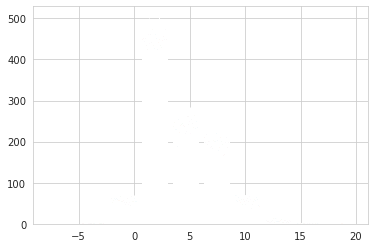

In [21]:
results_df['Update_No_Shoppers'].hist()

Most of the predictions are between 0 and 10.

2000 simulations only took a few seconds to run. So can increase number in order to increase confidence level of where shopper numbers would be for each delivery window time. At the same time, need to watch out for law of diminishing returns. There may be a limit to how many simulations could be done where there is no more change in shopper number distribution (mean/std dev will not shift drastically).

### Aggregated version.

In [16]:
# Define a list to keep all the results from each simulation that we want to analyze
all_stats = []

# Loop through many simulations
for i in range(num_simulations):

    # Choose random inputs for prev_no_shoppers and percent to target
    prev_no_shoppers = np.random.choice(prev_shopper_values, num_delivery_windows, p=shopper_values_prob)
    pct_to_target = np.random.normal(avg, std_dev, num_delivery_windows)

    # Build the dataframe based on the inputs and number of delivery windows
    df3 = pd.DataFrame(index=range(num_delivery_windows), data={'Pct_To_Target': pct_to_target,
                                               'Prev_No_Shoppers_Assigned': prev_no_shoppers})
    #Update number of shopper based prev no shoppers and percent to target
    df3['Update_No_Shoppers'] = df3['Pct_To_Target'] * df3['Prev_No_Shoppers_Assigned']
    df3['Update_No_Shoppers'] = df3['Update_No_Shoppers'].round()
    df3['Update_No_Shoppers'] = df3['Update_No_Shoppers'].astype(int)

    # We want to track prev no of shoppers,target value percent and updated shopper no over all the simulations
    all_stats.append([df3['Prev_No_Shoppers_Assigned'].mean(),
                      df3['Pct_To_Target'].mean(),
                      df3['Update_No_Shoppers'].mean()])

In [17]:
#All possible values at a given delivery window time frame
results_df = pd.DataFrame.from_records(all_stats, columns=['Prev_No_Shoppers_Assigned',
                                                           'Pct_To_Target',
                                                           'Update_No_Shoppers'])
results_df['Prev_No_Shoppers_Assigned'] = results_df['Prev_No_Shoppers_Assigned'].round()
results_df['Prev_No_Shoppers_Assigned'] = results_df['Prev_No_Shoppers_Assigned'].astype(int)
results_df['Update_No_Shoppers'] = results_df['Update_No_Shoppers'].round()
results_df['Update_No_Shoppers'] = results_df['Update_No_Shoppers'].astype(int)
results_df

,Prev_No_Shoppers_Assigned,Pct_To_Target,Update_No_Shoppers
0,4,0.969860,4
1,4,0.998341,4
2,4,0.994761,4
3,4,0.976779,4
4,4,1.005331,4
...,...,...,...
1995,4,1.003627,4
1996,4,1.007896,4
1997,4,0.991391,4
1998,4,1.009183,4


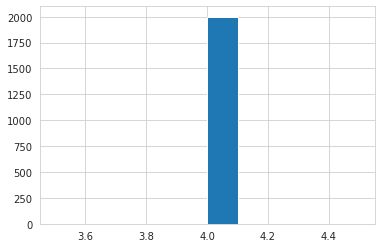

In [11]:
#Get distribution of Update_No_Shoppers
results_df['Update_No_Shoppers'].hist()

As we can see from the distribution, most common number of shoppers at a given time window is: 4